In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import mode, norm, lognorm, gamma, skewnorm, expon, beta, weibull_min, cauchy, t, kstest

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Source

Note that we will use a single digit in square brackets (i.e., [1]), to indicate one of the sources listed here, primarily for 1-3.

1. Noseong Park and Mahmoud Mohammadi and Kshitij Gorde and Sushil Jajodia and Hongkyu Park and Youngmin Kim (2018). Data Synthesis Based on Generative Adversarial Networks. [https://www.vldb.org/pvldb/vol11/p1071-park.pdf]. VLDB

    This paper introduces table-GAN, an approach to deep modeling to create synthetic tabular data through the use of convolutional neural networks (CNNs) and generative adversarial networks (GANs). Note that it was published in the same year as the next paper on TGAN, though it is by different authors. Note that source 2 below references this paper and its tableGAN approach.
    
2. Lei Xu and Kalyan Veeramachaneni (2018). Synthesizing Tabular Data using Generative Adversarial Networks. [https://arxiv.org/abs/1811.11264]. arXiv

    This paper introduces tabular generative adversarial networks (TGANs), a precursor to the CTGAN in the next paper and similar to the previous paper but utilizing recurrent neural networks (RNNs) in place of CNNs.
     
3. Lei Xu and Maria Skoularidou and Alfredo Cuesta-Infante and Kalyan Veeramachaneni (2019). Modeling Tabular Data using Conditional GAN. [https://arxiv.org/abs/1907.00503]. arXiv

    This paper introduces conditional tabular generative adversarial networks (CTGAN), a deep learning conditional GAN that improves, according to the authors, on their approach in the previous paper by introducing a conditional generator to the architecture.

4. Emiliano De Cristofaro (2024). Synthetic Data: Methods, Use Cases, and Risks. [https://arxiv.org/abs/2303.01230]. arXiv

    This paper is a good resource for understanding synthetic data generally.

5. Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

    This dataset comes from the University of California Irvine Machine Learning Repository, is based on 1994 Census data, and allows us to classify if given individuals make more than $50,000 per year. While gleaning insights out of the dataset is not the focus of this project, we do still need a dataset to work with as we test out generating synthetic data. We partially pick this dataset because it shows up in a number of the papers referenced for this project.

6. Alec Radford and Luke Metz and Soumith Chintala (2016). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. [https://arxiv.org/abs/1511.06434]. arXiv 
    
    This paper introduces deep convolutional generative adversarial networks (DCGAN), a GAN architecture that [1] relies on.


## Project & Introduction to Synthetic Data

My modus operandi is to start projects by finding interesting datasets and building out the other details from there. In this project, we will instead start with an application of deep learning and see if we can get it working on a tried-and-true machine learning dataset. We will try to build a deep learning model that creates synthetic data. Synthetic data is "artificially generated [data] that resemble[s] the actual data -- more precisely, having similar statistical properties" (De Cristofaro, 2024, p. 1).

Note that it is unclear at the outset of the project just how far into creating synthetic data models we will be able to get in this project. As we will see in the next section, the three research papers above that we will focus on for implementation are pretty complicated. My preference is to tackle that complexity head-on and see how far we can get, but I do want to recognize that each paper has numerous authors with terminal degrees, and this research may be part of some of the authors' theses, so I want to be careful in assuming that I may be able to recreate all of their work, even if I have their research papers to guide me. It may be that we get part of the modeling working, but we do not get a full version of the models from any of the papers. My read on the assignment is that progressing through the stages of building up synthetic data models fits with expectations, and I am really interested in tackling a project with this kind of complexity of theory and modeling, so we will see how far we can get in terms of building one of these models.

Due to the types of modeling, this project will include both supervised and unsupervised learning, and its primary deep learning will come from GANs.

Now, back to synthetic data.

Synthetic data has been in the air lately due to its proposed use to feed even greater amounts of data into burgeoning artificial intelligence models. This use of synthetic data is focused on increasing the amount of data that is available. If we have 1,000,000 rows of data, we can use a model to learn the ins and outs of that data and then create new synthetic rows to supplement the real ones. We could also use this use case for synthetic data to re-balance classes in the data.

We can also use synthetic data to protect privacy, the use case I am interested in.

If we have a dataset that includes personally identifiable information (PII) -- names, social security numbers (SSNs) or other unique identifiers, addresses, emails, dates of birth, etc. -- our first step would be to anonymize that data. One approach here would be to develop an algorithm for assigning an anonymized unique identifier for each unique individual based on the PII. We can feed PII into the model, let the model cluster by unique individuals it identifies based on the PII, and then have the model assign the anonymized identifier to each cluster. We could then drop all PII from the dataset and replace it with the anonymized identifier.

This is a good first step in that it removes data that can identify an individual directly, but we still have a problem. Someone may be able to use, for instance, high school graduation year, high school grade point average, courses taken in high school, race and ethnicity, and gender to reverse engineer who someone is. We cannot anonymize all data, including non-PII data, to reduce this risk since we would have nothing left to run analysis on. But, we can synthesize data. Instead of supplementing real data with synthetic data to increase the number of observations in the dataset, this time we can create a dataset that is entirely made up of synthetic data, allowing us to share the synthetic dataset for analysis since it matches the real data's statistical properties but while protecting privacy since we are not releasing any rows with real data, so there is no real person to tie any row back to.

This project will focus on "[g]enerative machine models [that] learn how a dataset is generated using a probabilistic model and [that] create synthetic data by sampling from the learned distribution" (De Cristofaro, 2024, p. 2). Relying on models we learned in class, generative adversarial models (GANs) seem like the obvious choice for this use case. (See the GAN section below for a deeper dive into GANs.) The Monet-image Kaggle competition leverages CycleGANs, and CycleGANs can in a sense be thought of as autoencoders, another model that we may want to look at here. Autoencoders convert an input to a reduced latent space (encoder) and then convert that latent space back into the original space (decoder). Once we train the autoencoder, we can pass random noise as input to the latent space and let the decoder translate that back into the full input space for the encoder. In this scenario, this means we could pass random noise into the latent space input for the decoder, and the decoder would convert that to the synthetic output we are looking for, in theory.

There are risks with synthetic data when it comes to privacy. While sharing completely synthetic data provides extra layers of protection, the statistical trends in the data may be strong enough that a nefarious actor could reverse engineer real identities from the synthetic data. One example of this is any value that shows up infrequently. The synthetic data should pick up on that and recreate that value with a smaller frequency, and that can lead to many common issues when dealing with small n counts in shared datasets. One attempt to address this is l-diversity where each categorical feature must have at least l factors to try and protect against this issue (Park et al., 2018, pp. 1072-1073). 

We also need to worry about very strong correlations between features. The synthetic data will pick up on this, and, again combined with small n concerns, this broadens the information a bad actor has to try and re-identify from the synthetic data. (De Cristofaro, 2024, p. 4, Attribute Disclosure section).

Another concern is re-identification attacks where the attacker uses other sources combined with the synthetic data to re-identify individuals. Fields like SSNs or names are direct identifiers. Fields like race, ethnicity, and gender are quasi-identifiers (QIDs). Attackers can use these QIDs to supplement statistical trends in the synthetic data to piece together who an individual is (Park et al., 2018, p. 1072). We can control the synthetic data we share, but we cannot control what other dataset or outside information someone may have access to.

I do want to point out that the De Cristofaro paper that I am mostly referencing in this section calls out that synthetic data to protect privacy as we will look at it in this project is not necessarily as safe as it may at first seem, providing "little additional protection compared to anonymization techniques, with privacy-utility trade-offs being even harder to predict" (De Cristofaro, 2024, p. 5). The paper recommends looking at differential privacy as a better option on top of synthetic data. Differential privacy introduces noise into the data that is shared, muddying up what is real or not. This highlights the tension between privacy and utility of synthetic data since adding in noise to protect privacy inherently reduces the statistical accuracy of the synthetic data compared to the real data (De Cristofaro, 2024, p. 1). And, regardless of what solution we use, there really is no way to get both privacy and utility for underrepresented values or classes in the data since any upsampling to protect privacy by necessity alters the statistical accuracy of the synthetic data (De Cristofaro, 2024, p. 6).

The issues raised here are not exhaustive, but they hopefully provide an introductory sampling of the kinds of issues we are concerned with and how synthetic data attempts a response to those issues. Zooming out and acknowledging the complexities and concerns mentioned here and referenced in the cited papers, we do need to start somewhere. The goal of this project is to understand how deep learning models for synthetic data work, trying to build a model up while following along with the research papers. We need a solid foundation in synthetic data before adding in too many open issues that are yet unsolved for synthetic data modeling. The next step is to plan out how we will work with the research papers to try to build our own synthetic data model.

### Note

I had the opportunity to talk with researchers who build synthetic data generation solutions. They caution that there are many research papers that propose solutions for generating synthetic data, but many of those are untested in production environments, so I may risk trying to recreate solutions from papers that have not been used in practice. Their general advice is to avoid GANs due to computation and sample size requirements.

That all said, I only got to speak with these researchers after completing most of this project, so we will stick with the GAN papers above. Just want to call this out here since I would have adjusted the approach had I talk with experts before getting so far into this project.


## Neural Network Background

This section covers background material that readers are likely to know having gone through this deep learning course or other supplementary information needed for understanding the research papers. We separate these summaries out to shorten the paper summaries later.

### Generative Adversarial Networks (GANs)

GANs are machine learning architectures (networks) that use competing neural networks (adversarial) that generate (generative), in this case generating synthetic data. The competing networks are the generator and discriminator. The generator takes in a noise vector as input and, initially, generates random noise. The discriminator takes in the output of the generator along with real data and distinguishes between the two, passing its labeling of real and synthetic data back to the generator. This cycle repeats again and again, each time the generator getting better at generating real-looking synthetic data and the discriminator becoming more discerning between real and synthetic data. The goal is that the generator will eventually win out and produce synthetic data that a well-refined discriminator cannot discern as different from real data. At this point, we have a generator model that we can use to produce real-enough synthetic data.

The standard objective function for GANs uses a minimax function between the generator and discriminator. The generator minimizes this loss, and the discriminator maximizes it.

### Convolutional Neural Networks (CNNs)

CNNs are feed-forward neural networks where we apply kernels or filters -- rectangular windows -- that slide along the dimensions of the input matrices. For tabular data, we transform an input row into a square matrix, zero padding as necessary to fill out the square matrices, so we can think of the input for tabular data as appearing like an image with a width and a height and with values at each pixel. For example, if we have an input row with 13 features, we can transform that 1x13 vector into a 4x4 matrix and pad out the 2nd, 3rd, and 4th columns in the final row since the original row does not have enough features to fill those cells in the transformed matrix.

When we focused on images as inputs in a previous week's project, the CNN kernels summarized or abstracted elements of the images. If we added multiple kernels per layer, then each kernel would pick up on different aspects of the image. When we added multiple layers, each layer picked up on higher levels of abstraction. Note that in the CNN project we started with rectangular images with three channels and reduced those down with convolutional layers. In [1], we use "deconvolutions" or fractionally strided convolutions, and we then follow those with convolutions, the opposite direction of what we saw with the images in the previous project. We will go into the specifics for [1] below.

One aspect of CNNs to highlight is striding. Striding occurs when we slide a filter across a matrix but skip certain amounts at each step. For example, if we have a 10x10 input matrix and a 2x2 filter, without striding we would start with the filter in the upper-left of the matrix, calculate, and then shift the filter to the right by one. If we use a stride of 2, when we move that filter to the right, we skip a column and move to the second column to the right. A stride of three would skip two columns and jump to the third to the right.

For fractionally strided convolutions, we use strides that are less than 1. Strides greater than 1 reduce the output dimensions, so strides less than one increase the output dimensions. If we stride by 1/2, we add rows and columns of 0s between the rows and columns of the original matrix. This will double the dimensions of the input. We can then apply a convolution layer to the upsampled output with additional padding but with no pooling or striding to keep the dimensions of the upsampled output the same but to fill in the 0s. This process shows up as "deconvolutions" but is implemented with fractional striding in order to increase instead of decrease the dimensions of the input to that convolutional layer.

### Deep Convolutional GAN (DCGAN)

This model is explained in [6] and shows up in the architecture for [1]. DCGANs are GANs that use specific CNN architectures for both the generator and discriminator. Page 3 of the DCGAN paper has a summary list of the details for DCGAN that we will copy over here:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers. [Radford et al., 2016, p. 3]

### Recurrent Neural Networks (RNNs)

RNNs introduce recurrence, a deviation from feed-forward network architectures. CNNs are one example of feed-forward networks where the inputs get passed forward through the network but do not move sideways or backwards. In RNNs, we have recurrent layers that look sort of like hidden layers in other artificial neural networks (ANNs) but that are able to pass their output back into themselves, creating a loop in place of feed-forward hidden layers. Technically the RNN has one recurrent hidden layer, but we can think of that repeating hidden layer as unfolding into sequential hidden layers that take inputs from the previous hidden layers as well as new inputs from the tabular data. Note that the weights for the hidden recurrent layers are shared in an RNN, that being different from hidden layers in other architectures having their own separate weights.

We will cover RNNs in [2] in more detail below, but the general idea is that, for a given row, we will pass the first feature into the RNN, and then we will pass output weights from that first feature back into the RNN along with the second feature, then we will pass weights from that output back into the RNN along with the third feature, and on and on. The focus here is that we are treating features in a row like sequential inputs where each input can receive information from previous inputs. This idea of rows as sequential inputs for tabular data is interesting in opening up the possibility of using RNNs to generate tabular synthetic data.

[2] also leverages long short-term memory (LSTM), an RNN strategy to address the model forgetting from sequential elements that it saw further away from the current element. For example, if we have 50 columns to generate, we may find that the RNN remembers the previous dozen or so columns, so, once we get to column 30, the model no longer factors in the first dozen columns. This means that earlier columns may not be able to inform later columns, so we are leaving information between columns on the table. LSTMs address this by adding in ways to influence how much information a layer remembers or forgets from previous layers, the goal being to keep more impactful information from further back while dropping less impactful information from more recent elements.

### Word Embeddings (do we need these?)

Only [2] references embedding vectors, but we will introduce them here in case we end up needing them. Machine learning models work with numbers, not with text, so we need a way to turn text into numbers. One approach could be to identify all the unique words in a feature -- the vocabulary for that feature -- and then one-hot encode each individual word, creating a one-hot encoded matrix per feature. Skipping over some of the cons of this approach, next we could instead create a matrix with one row per row in the base dataset and one column for each word in the combined vocabulary, and then we could put 1s for each word that shows up in a given row for a feature. A third approach could be to create a list of the vocabulary for each feature, and then we can replace each word that shows up in that feature with the index of that word in the vocabulary list.

From here, there are more complicated embedding approaches such as TFIDF, Word2Vec, and GloVe. We will not go into the specifics of these, but each has a different way of converting text into numbers.

I am surprised that word embeddings do not show up more often across all three papers. When we review the papers in detail below, we will keep an eye out for what might be going on here or if the researchers assume that implementations will handle embeddings without their needing to direct how.

### Variational Autoencoders (VAEs)

[3] references a variation on traditional VAEs, but we will not be exploring those in this iteration of the project. If you do want to learn more, the steps would be to learn about autoencoders, then variational autoencoders, and then CTGAN's variant for tabular VAEs.


## Research Paper Summaries

The first three papers at the start of the notebook present different approaches to generating tabular synthetic data. All three use GANs for the generative aspect of their architectures. [1] and [2] come earlier than [3] and have slightly simpler architectures, though those implementations are still complicated. [3] comes later and looks more effective than [1] and [2], but it introduces an extra layer of complexity with a conditional GAN and more complex normalization for continuous columns.

For terminology, we will refer to the model in [1] as table-GAN, in [2] as TGAN, and in [3] as CTGAN.

Each paper has some level of review of other methods for preserving privacy and utility. The papers cover many areas related to risk, exposure, and competing methods. Our focus is on seeing how far we can get in implementing generative models, so we will skip recaps of other information from the papers.

We will save some of the details on specific architectures until closer to modeling later on since we will need to translate those details into source code at that point. We also move some portions of the research papers such as loss or evaluation strategies into separate sections below the summaries since we will need to decide how to deploy those later.

### [1] Data Synthesis Based on Generative Adversarial Networks

This paper introduces table-GAN, a CNN approach to generation. table-GAN handles categorical, discrete, and continuous data but leaves out other types of data such as time-series data (Park et al., 2018, p. 1071). table-GAN consists of three ANNs:
1. Generator
2. Discriminator
3. Classifier (Park et al., 2018, p. 1072)

The first two ANNs are standard in GANs, and table-GAN leverages DCGAN in particular for these two. DCGAN is a form of CNN, so we will need to prepare the data so that a CNN can run on it. The classifier is a new addition that checks for "semantic integrity," learning what combinations of values in different columns are legitimate so we do not end up with a nonsensical combination such as generating the city of Boulder in the state of Kansas (Park et al., 2018, p. 1072).

table-GAN includes three loss functions: 
1. The standard GAN objective function
2. Information loss. This takes the mean and standard deviation for each feature and across all the rows in that feature, making sure that synthetic rows have the same statistical properties as real rows. The goal is for this loss to be 0 for both mean and standard deviation, indicating that the discriminator may not be able to distinguish between the real and synthetic data. The paper uses an exponentially weighted moving average to approximate the mean and standard deviation for each feature.
3. Classification loss. This maintains semantic integrity by predicting one feature by the other features, the loss being the discrepancy between the prediction by the classifier and what is produced by the generator. (Park et al., 2018, p. 1075-6)

The discriminator uses the standard loss, the classifier uses classification loss, and the generator uses all three losses.

table-GAN utilizes three evaluation metrics, all detailed in the Evaluation section below:
1. Distance to the closest record (DCR). DCR calculates the Euclidean distance between a synthetic record and the closest real record, applying attribute-wise normalization so that each attribute contributes equally to the distance. DCR = 0 leaks information since the synthetic data is the same as a real record.
2. Statistical comparisons. For these, we compute per-attribute metrics and compares those between real and synthetic data. We want these to be very close.
3. Machine learning score similarity. This method trains separate classifiers or regressors on the real and synthetic tables and then checks if the F1 score for classification or the mean relative error (MRE) for regression are the same between the models trained on the real and the synthetic data. (Park et al., 2018, p. 1078)

We will use the second and third evaluation options here to evaluate our models later.

### [2] Synthesizing Tabular Data using Generative Adversarial Networks

This paper introduces TGAN, a modeling approach that differs from [1] in:
- using RNNs instead of CNNs, using LSTM with attention in particular
- focusing on marginal distributions more than optimizing for prediction accuracy on synthetic data
- explicitly learning marginal distributions for each column by minimizing the Kullback-Leibler (KL) divergence (the KL divergence measures how different two probability distributions are) (Xu and Veeramachaneni, 2018, p. 2)

TGAN does introduce a few new ideas. It is built to handle multi-modal continuous data -- continuous data has more than one value that is the most common, visually showing up as distributions with more than one peak when plotting the distribution. Multi-modal continuous data causes issues when we use tanh to normalize to the range [-1,1]. If any of the modes are near -1 or 1, or at least not near the center or 0 for tanh, we risk running into vanishing or exploding gradients during backpropagation, similar to how these gradient issues show up for S-shaped activation functions when we are working in regions not near their center. (Xu and Veeramachaneni, 2018, p. 2-3)

TGAN's approach here is interesting and worth exploring for a moment.

TGAN applies a workaround with Gaussian kernel density estimation (KDE) and Gaussian mixture models (GMMs). Gaussian KDE is a process by which we can imagine taking a certain window of set width, sliding that window horizontally along the actual distribution of a continuous variable, and taking an average at each step of that sliding. The Gaussian portion means points that are closer to the center of the window have more weight, and points further away have less weight similar to what we see with a Gaussian distribution. (Xu and Veeramachaneni, 2018, p. 3)

GMMs are distributions that are combinations of Gaussian distributions. In this scenario, if a continuous variable has more than one mode, we can model each mode as a Gaussian distribution, and then the variable as a whole is a combination of each of those individual Gaussian distributions. So, we use GMMs to cluster each continuous random variable to estimate the number of modes. Later we can sample from the GMM. We calculate the probability that a value comes from each of the modes, and then we pick one of the modes and normalize against it. Note that the multinomial distribution we mentioned in tandem with GMMs for handling multimodal continuous variables shows up in that we can think of each mode as a factor level in the multinomial distribution. (Xu and Veeramachaneni, 2018, p. 3)

Note that we will need to use these GMMs with KDE if we are handling multimodal data. As we will see later, the dataset we use does not have clear multimodal continuous data, so we may let this addition go for this pass of this project.

With numeric variables addressed, we can pivot to categorical variables. The main issue we face here is that discrete variables are not differentiable, causing backpropagation to fall apart. TGAN gets around this by one-hot encoding categorical variables and then using softmax along with adding noise to the new one-hot encoded binary variables to create differentiable units. The paper refers to this as "smoothing" categorical variables. (Xu and Veeramachaneni, 2018, p. 3)

TGAN uses the standard GAN loss for the generator but adds the KL divergence in different ways for continuous and discrete variables. The discriminator uses conventional cross-entropy loss. (Xu and Veeramachaneni, 2018, p. 4)

TGAN uses two evaluation metrics. The first is what we called machine learning score similarity when summarizing [1] above. The second is pairwise mutual information between two random variables -- the amount of information about one random variable that you can determine based on information in the other random variable. (Xu and Veeramachaneni, 2018, p. 2-3).

Pairwise mutual information may be something we want to explore as part of our evaluation metrics.

### [3] Modeling Tabular Data using Conditional GAN

Next we move on to CTGAN, the most complex of the approaches we look at here. It is unclear if we will try to model CTGAN ourselves, but it is helpful to understand where simpler models may come up short and how we could look at improving them.

The CTGAN paper covers much of the same ground as the previous two papers in terms of setup and background context, especially [2] since it is by some of the same authors, but this paper does introduce an additional issue with severe imbalance in categorical columns. This paper also tests out tabular variational autoencoders (TVAEs), though it finds that TVAEs underperform compared to CTGANs. The paper also introduces a synthetic data benchmarking system that is open source and extensible. But, aside from those, the overall setup for CTGAN is familiar to us at this point. (Xu et al., 2019, p. 1-2)

The new problem since [2] is that highly imbalanced discrete columns result in mode collapse and a lack of representation for minority classes. CTGAN uses conditional generators and training-by-sample to address the issue of class imbalance in discrete features where a minority class shows up few enough times that the generator may not reliably learn to generate those values. (Xu et al., 2019, p. 4-5)

First we look at the role of the conditional generator. If we resample from the real data to pick up more instances of the minority class, then the generator learns a resampled distribution, not the true distribution. We instead resample evenly across classes during training and then later recover the actual distribution during test. This means we take the same number of rows for each class during training. For each of those classes, the generator learns to generate a row conditioned on that class value for that column. The generative side of this is that we pivot to a generator that generates full rows based on a new input of a given class value. The paper calls this a conditional generator and calls a GAN built on it a conditional GAN. (Xu et al., 2019, p. 4)

Implementing the conditional GAN poses a few issues:
1. We need to create a representation for the condition and develop an input for it into the model
2. The generated rows must retain the condition we pass into the generator
3. The conditional generator must learn the real conditional distribution, meaning $P_{generated}(row|class) = P_{real}(row|class)$. We can recreate the original distribution from the evenly sampled distribution we discussed in the last paragraph by multiplying by the probability of each class showing up in each column, so $P_{generated}(row|class) P(class in real distribution)$. (Xu et al., 2019, p. 4)

The paper uses conditional vectors as representations for the conditions. For the conditional vector, we one-hot encode the discrete columns. For each one-hot encoded discrete column, we can put a mask of 1 when the value for that column matches the right one-hot encoded column. We repeat this for each discrete column and then concatenate each of the mask vectors together to create the conditional vector, so we end up with, for example, a vector such as 000100100100110001000 capturing the categorical values for that row. (Xu et al., 2019, p. 5)

But the generator can create conditional vectors with incorrect masks, vectors where we put 1s in places where they should not be. For example, for the one-hot encoded representation for a single discrete column, the generator may provide more than one 1 for that column, an invalid one-hot encoded vector. We add a cross entropy loss between generated and real conditional vectors so that the generator ends up learning to produce only valid conditional vectors, the new addition for the generator loss. (Xu et al., 2019, p. 5)

Last, we use the training-by-sampling procedure to perform the adjusted sampling. This procedure performs the adjusted sampling for CTGAN. The crux of this procedure is that we adjust the probability mass function (PMF) for classes in a given feature by taking the logarithm of each class's frequency, increasing the probability that we sample classes with smaller real probabilities. (Xu et al., 2019, p. 5)

The final new item to discuss comes during evaluation. It is worth noting that the CTGAN paper introduces a whole new benchmarking tool -- the [SDGym](https://github.com/sdv-dev/SDGym) -- that is open-source and available for use. The paper points out that other papers different in how they benchmark synthetic generation models, so standardizing on a benchmarking tool could provide better comparative insight between models. This tool utilizes evaluation metrics that we explain below and that were already seen in previous papers while also adding some nuance to those approaches that we have not yet seen. [p. 7]

Depending on how our implementation of evaluation metrics goes, we may want to consider using this tool across each of the different model iterations.

The final note here is that this model uses yet another GAN: PacGAN, a variant of DCGAN, DCGAN underlying the approach in [1]. We are unlikely to end up implementing CTGAN, so we will put PacGAN aside for now.

## General Summary

So where does that all leave us? Well, first, if this seems complicated to you, then we are in agreement about that. One thing I have learned reading a number of research papers related to synthetic data generation, many more than the handful listed in the Sources section above, is that no single paper tends to build its solutions from scratch or first principles. There is often a chain of building on top of one or more approaches in other papers, sometimes just referencing those papers and leaving the reader to interpret how to implement the specifics, and in other cases laying out in more detail what those implementation details look like. We will do our best to recreate some working solutions, but I also want to create space to attempt solutions rather than require refined, optimized, and/or simple solutions.

For the papers we looked at in particular, each take different approaches to modeling tabular synthetic data generators. The first uses CNNs, DCGAN in particular. The second uses RNNs, though it has extra layers of how to model multimodal data in particular while also providing solutions for handling non-differentiable discrete data. Before doing a research paper review, my thinking was to look at RNNs for this task, though admittedly much less complicated than what we see in [2]. The third paper we looked at looks like it shifts back to DCGAN as its core ANN, though it introduces conditional GANs to handle imbalance in categorical features.

Though we let it fade into the background above, each paper references row generation to be some version of sampling from a joint probability distribution where each feature is treated as a random variable. The way we determine those is up for question, and, if we are using GANs, we will not necessarily know the individual random variables of the joint distributions in any detail since we set the ANNs up to learn them for us.


## Preprocessing and Exploratory Data Analysis (EDA)

Alright. That was a lot of text to set the background for the actual design and programming. Now we can pivot to exploring the dataset that we are working with.

This dataset has 48,842 total records, 32,561 in `adult.data` and 16,281 in `adult.test`, so a $\frac{2}{3}$ to $\frac{1}{3}$ train-test split. We will combine these and later create our own train-test split. There has been some minor preprocessing already done on the data that we are okay with, though we will explore the data for further preprocessing. We will also check if we want to keep the current train-test split or combine them and recreate our own. 

There are 14 features and 1 target. This dataset lends itself to binary classification predicting if a row makes more or less than $50,000 in income. However, since our task is generating synthetic data, our preprocessing and EDA will focus on getting the data ready for the generative models as summarized above. 

For example, distinguishing between continuous and discrete variables will be important during modeling, but we will want to slowly to figure out how each model handles these two types of data, so we should focus on selecting which continuous and discrete features to start with and which to add and in what order once we have the basics down. We will want to find a continuous column with one mode to start out with for modeling. We will then want to explore a continuous column with more than one mode, at first to see the problems that causes for modeling and then to see how mode-specific normalization may address the issue.

Pulling from the data dictionary in the `adult.names` file and from the UCI link in the Sources section above, here is a quick summary of the base features:

- `age`: numeric
- `workclass`: 8 nominal levels representing type of work such as private, federal government, local government, etc.
- `fnlwgt`: numeric combination of different Census Bureau weights; we will drop this since we are not extrapolating to population estimates
- `education`: 16 ordinal levels representing educational attainment
- `education-num`: Looks like a numeric representation of `education` feature
- `marital-status`: 7 nominal levels
- `occupation`: 14 nominal levels
- `relationship`: 6 nominal levels
- `race`: 5 nominal levels
- `sex`: binary
- `capital-gain`: numeric
- `capital-loss`: numeric
- `hours-per-week`: numeric hours worked per week
- `native-country`: 41 nominal levels
- `income`: binary target feature


In [2]:
col_names = [
    'age'
    , 'workclass'
    , 'fnlwgt'
    , 'education'
    , 'education-num'
    , 'marital-status'
    , 'occupation'
    , 'relationship'
    , 'race'
    , 'sex'
    , 'capital-gain'
    , 'capital-loss'
    , 'hours-per-week'
    , 'native-country'
    , 'income'
]

# Source CSVs have spaces after commas, so we drop them with the skipinitialspace param
df = pd.concat([
    pd.read_csv(
        './data/adult.data'
        , names=col_names
        , skipinitialspace=True
    )
    , pd.read_csv(
        './data/adult.test'
        , names=col_names
        , skipinitialspace=True
        , skiprows=1
    )
# We will drop fnlwgt here since we do not use
]).drop(columns=['fnlwgt'])

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n\n')
df.info()

The dataset has 48,842 rows and 14 columns


<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  income          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.6+ MB


No surprises here. The datatypes line up with what we are expecting to see based on the dictionary. Next we will check for nulls and invalid values.

In [3]:
print(f'There are {df.isnull().sum().sum()} nulls in the source dataset')
print()
print()

for col in df:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 0 nulls in the source dataset


age: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]

workclass: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

education: ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']

education-num: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

marital-status: ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

occupation: ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handle

Most of the values look okay. We do need to clean up ?s and combine the `income` categories that differ by having a period. Aside from that, the range of values are what we expect to see for each feature, so we do not need to drop rows based on invalid values. We will test for outliers with visualizations below.

`adult.names` tells us that the curators of the data replaced unknowns with '?'s, and we see no direct nulls. We can see these show up in `workclass`, `occupation`, and `native-country`.

In an interesting turn, we are less interested in what specific factor levels mean for this project. We are concerned with their distributions and in checking that any combinations of values are valid, but, for example, while `Married-AF-spouse` seems like married to a spouse in the air force compared to `Married-civ-spouse` possibly meaning married to a civilian spouse, it actually is not important for us to clarify or confirm.

The final issue is in `income` and is that each category shows up twice: once with a period and once without, so, for example, having both '>50K.' and '>50K'.

In [4]:
print(
    f'There are {df[df.isin(['?']).any(axis=1)].shape[0]:,} rows with ?s, '
    f'{df[df.isin(['?']).any(axis=1)].shape[0]/df.shape[0]:,.3f} of the total rows in the dataset'
)
print()
print()
 
# Dropping based on the isin() condition is losing more rows than expected, so we drop this way instead
df = df[
    (df['workclass'] != '?')
    & (df['occupation'] != '?')
    & (df['native-country'] != '?')
]

# Remove the periods
df.loc[df['income'] == '<=50K.', 'income'] = '<=50K'
df.loc[df['income'] == '>50K.', 'income'] = '>50K'

print(f'The are {df.shape[0]:,} rows remaining in the dataframe')
print()
for col in df[['workclass', 'occupation', 'native-country', 'income']]:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 3,620 rows with ?s, 0.074 of the total rows in the dataset


The are 45,222 rows remaining in the dataframe

workclass: ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

occupation: ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

native-country: ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yug

Only 7% of the rows have missing values. The complexity of this project is focused on modeling, so, to avoid adding more layers of complexity here, we will drop the rows with missing values, keeping 45,222 left for us to experiment with.

Next we check out the single ordinal feature.


In [5]:
df[['education', 'education-num']].drop_duplicates().sort_values(by='education-num')


,education,education-num
224,Preschool,1
416,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
219,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


We see that `education-num` is, in fact, ordinal -- matching what we see in the data dictionary -- corresponding to `education` with higher numeric values equivalent to further education. The dataset may have a numeric encoding for `education` because it is the only ordinal categorical feature. We will want to make sure to keep one of these during modeling later so we do have an ordinal feature for testing.

### Continuous Features

The research papers mention that one approach to generating synthetic data is to sample from a joint distribution where we know the distribution for the random variable in each feature. This means we need to begin identifying distributions for numeric data. We will add that step in during EDA here, though we should note that this process can be difficult. Real world data often does not fit cleanly into known distributions, though it may still follow those distributions generally.

#### Distribution Fitting

We will use two approaches for determining distributions: the Kolmogorov-Smirnov (KS) test and visual inspection.

For our use of the KS test, it checks if the data comes from the specified distribution. We will fit different distributions to the data to estimate distribution parameters. We then plot the probability density functions (PDFs) on top of the histograms. For the KS test, instead of using PDFs on top of histograms to compare the fits, we instead sample from the distributions and compare the shape of the sampled data to that of the real data. A lower KS test statistic corresponds to less of a difference, meaning we have a better fit.

The KS test also gives p-values with the following hypotheses:
- $H_0$: data comes from the specified distribution
- $H_1$: data does not come from the specified distribution

As a teaser, all of our tests end up with large KS test statistics and p-values much, much smaller than 0.05, so we do not find sufficient distributions. That does not mean that the distributions are incorrect for the data. It just means that with the initial KS test and the process we are using, we do not have strong statistical evidence to select one of the distributions.

For the visual inspection, we look at the PDF curves overlaid on top of the empirical histograms to determine fit.

This process is okay for what we need it to do for now. Our goal is to understand the data better, not to find the perfect distributional fit. While sampling from a joint distribution where we have modeled each feature as a random variable with a known parametric distribution is one approach to generating synthetic data, we are looking at deep learning solutions, so we do not want ot spend too much time refining the distribution fitting process and take away from the other modeling.


In [6]:
# Returns basic measures of central tendency
def gimme_some_averages(col):
    print(f'Mean of {col}: {np.mean(df[col]):.2f}')
    print(f'Median of {col}: {np.median(df[col])}')
    print(f'Mode of {col}: {mode(df[col])}')
    print()


Mean of age: 38.55
Median of age: 37.0
Mode of age: ModeResult(mode=np.int64(36), count=np.int64(1283))



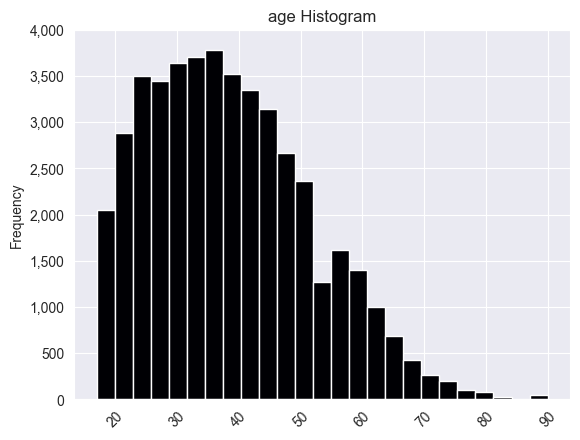

In [7]:
ax = df['age'].plot(
    kind='hist'
    , bins=25
    , title='age Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('age')


`age` has a bit of a right skew to it. The mean and median are relatively close, and the highest age is a little over twice as much as both. Based on interests in the papers, we only see one mode, so this will be a good numeric feature to test out early before adding in more complex modeling to handle multimodal numeric data.

We have a number of distributions that appear right skewed when compared to a normal distribution. We will start by checking against the distributions in `gimme_some_distributions` above. Since we will not get a clear winner, we will also try handling outliers to see if that clarifies the underlying distribution.

In [8]:
# Fits distributions, plots PDFs of those fitted distributions, and runs and outputs KS tests
def gimme_some_age_distributions(col, nbins):
    params_expon = expon.fit(col)
    params_norm = norm.fit(col)
    params_skewnorm = skewnorm.fit(col)
    params_lognorm = lognorm.fit(col)
    params_t = t.fit(col)
    params_gamma = gamma.fit(col)
    params_beta = beta.fit(col)
    params_weibull = weibull_min.fit(col)
    params_cauchy = cauchy.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    plt.plot(x, norm.pdf(x, *params_norm), color='g', label='Normal')
    plt.plot(x, skewnorm.pdf(x, *params_skewnorm), color='b', label='Skewed Normal')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), color='c', label='LogNormal')
    plt.plot(x, t.pdf(x, *params_t), color='m', label="Student's T")
    plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma')
    plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull')
    plt.plot(x, cauchy.pdf(x, *params_cauchy), color='tab:pink', label='Cauchy')
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['norm', *[*kstest(df['age'], 'norm', params_norm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['skewnorm', *[*kstest(df['age'], 'skewnorm', params_skewnorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['lognorm', *[*kstest(df['age'], 'lognorm', params_lognorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['t', *[*kstest(df['age'], 't', params_t)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['cauchy', *[*kstest(df['age'], 'cauchy', params_cauchy)]], (-1, 3)), columns=col_names)
    ], axis=0
    )

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


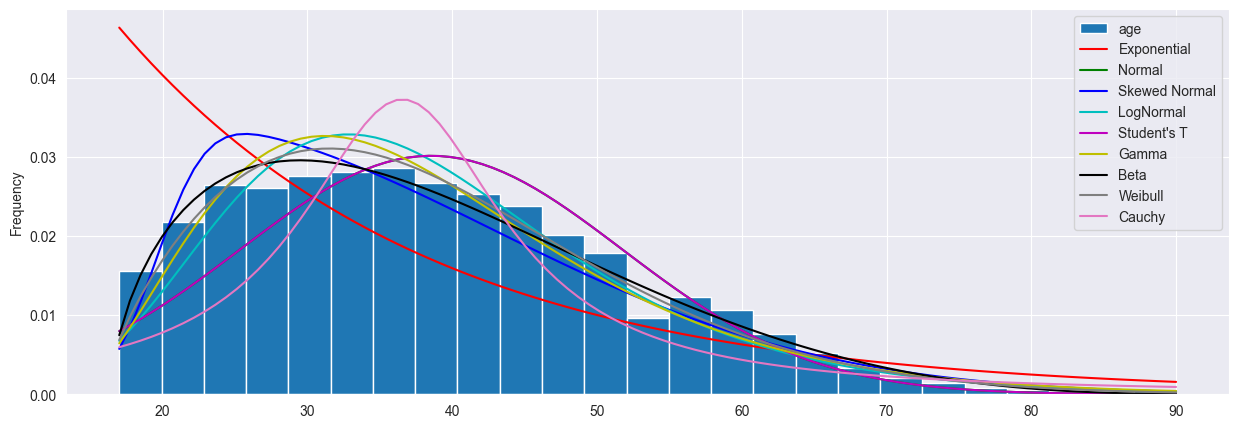

  distribution  statistic         pvalue
0         beta   0.036362   2.193863e-52
0      weibull   0.037578   6.403220e-56
0      lognorm   0.043856   5.100988e-76
0        gamma   0.048546   4.673454e-93
0            t   0.060890  3.419930e-146
0         norm   0.060896  3.192619e-146
0     skewnorm   0.069555  1.116308e-190
0        expon   0.164534   0.000000e+00
0       cauchy   0.130859   0.000000e+00




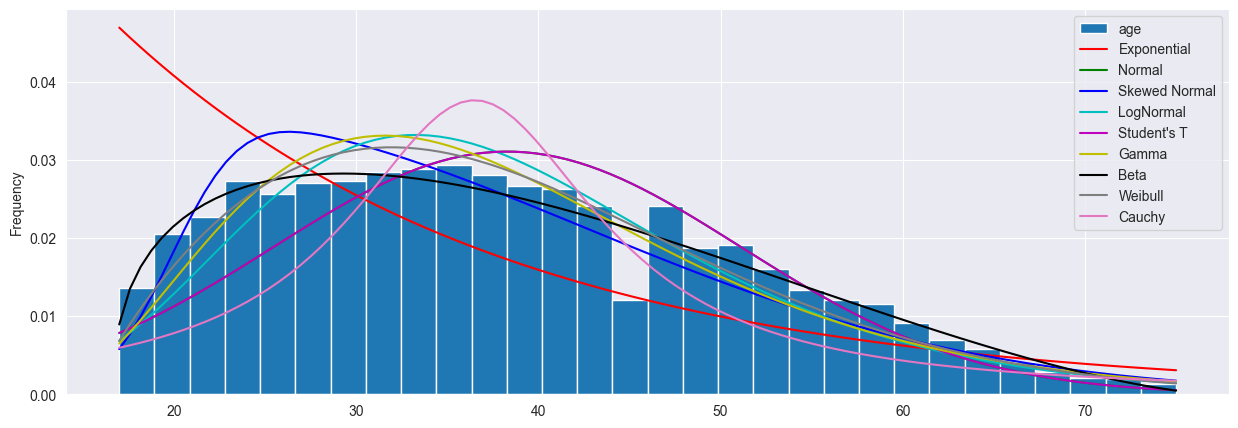

  distribution  statistic         pvalue
0         beta   0.031872   2.408832e-40
0      weibull   0.042691   4.686997e-72
0      lognorm   0.048334   2.996781e-92
0        gamma   0.053188  1.251845e-111
0            t   0.058579  2.470284e-135
0         norm   0.058582  2.409088e-135
0     skewnorm   0.073978  1.124374e-215
0        expon   0.168465   0.000000e+00
0       cauchy   0.130183   0.000000e+00


In [9]:
print(gimme_some_age_distributions(df['age'], 25))
print()
print()

# Removing outliers above 1.5 times the interquartile range
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
print(gimme_some_age_distributions(df.loc[df['age'] < upper_limit, 'age'], 30))



Cutting the outliers improves the KS statistic but does not change the overall distribution fitting story, so we will keep the outliers in. We reject the null hypothesis for all the KS tests, indicating that none of these distributions capture the actual data.

Visually, the beta distribution looks as good as a couple of others, and the beta distribution has the smallest KS statistic, so we can stick with this distribution for this feature. We will snag

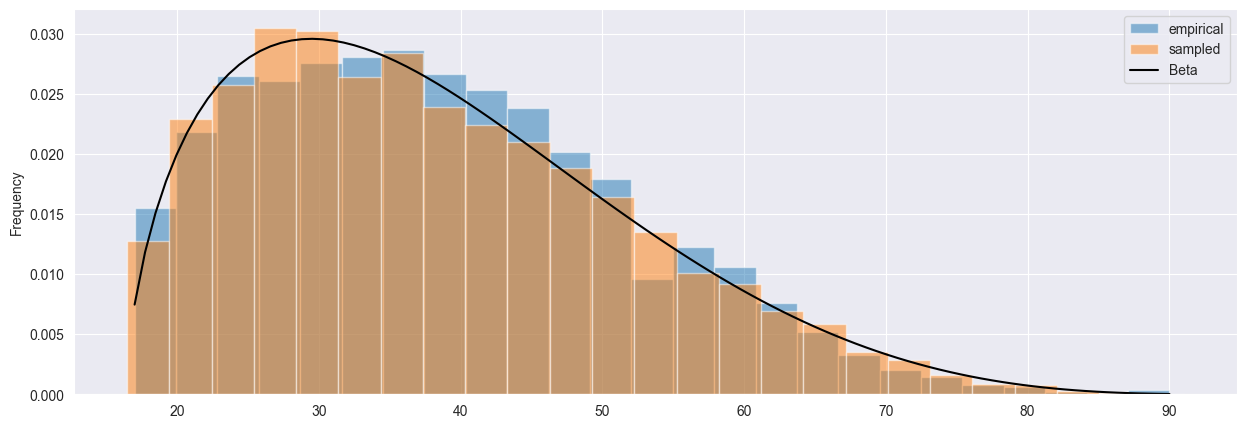

Beta distribution parameters are:
alpha=1.6420
beta=4.2078
location=16.3570
scale=78.6749


In [10]:
params_age = beta.fit(df['age'])

df['age'].plot(
    kind='hist'
    , bins=25
    , density=True
    , figsize=(15, 5)
    , alpha=0.5
    , label='empirical'
)
plt.hist(
    beta.rvs(a=params_age[0], b=params_age[1], loc=params_age[2], scale=params_age[3], size=10000)
    , bins=25
    , density=True
    , alpha=0.5
    , label='sampled'
)
xs = np.linspace(min(df['age']), max(df['age']), 100)
plt.plot(xs, beta.pdf(xs, *params_age), color='k', label='Beta')
plt.legend()
plt.show()

print(
    f'Beta distribution parameters are:\nalpha={params_age[0]:.4f}\nbeta={params_age[1]:.4f}\n'
    f'location={params_age[2]:.4f}\nscale={params_age[3]:.4f}'
)


With that, we have the info we need from `age`. Next we move onto `capital-gain`.

Mean of capital-gain: 1101.43
Median of capital-gain: 0.0
Mode of capital-gain: ModeResult(mode=np.int64(0), count=np.int64(41432))



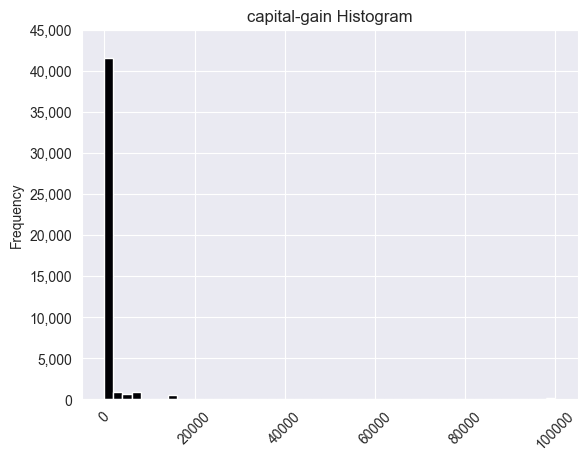

In [11]:
ax = df['capital-gain'].plot(
    kind='hist'
    , bins=50
    , title='capital-gain Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('capital-gain')


The outliers for `capital-gain` are more pronounced than what we saw in `age`. The median and mode are both 0, but the mean is much higher. This is due to the high values moreso than due to the amount of non-zero values. This plot already looks problematic. Any sort of sampling we do is likely to return just 0s.

In [12]:
print(
    f'There are {df.loc[df['capital-gain'] != 0, 'capital-gain'].shape[0]:,} rows with non-zero values for capital-gain, '
      f'{df.loc[df['capital-gain'] != 0, 'capital-gain'].shape[0] / df.shape[0]:0.2f} of the total number of rows\n\n'
)
df['capital-gain'].value_counts().sort_index()


There are 3,790 rows with non-zero values for capital-gain, 0.08 of the total number of rows




capital-gain
0        41432
114          8
401          2
594         42
914         10
         ...  
25236       14
27828       56
34095        4
41310        3
99999      229
Name: count, Length: 121, dtype: int64


About 92% of the data has 0s for `capital-gain`, a severe imbalance between values for this feature. We cannot drop 92% of the dataset because we lose too much data. We could look at dropping the 8% that is non-zero, but then we have a feature of all 0s, not a very informative feature, and it is useless in terms of modeling or predictive power. The data looks like it has already been winsorized for everything above 99,999. We could trim that cutoff much lower, but it does not solve the core imbalance issue.

We will try to fit distributions to the data. The heavy imbalance of 0s makes this difficult. We will lean into distributions that are known to handle heavy right skew better, so the list of distributions we test out here will be smaller than in the previous feature, though the general logic remains the same.


In [13]:
def gimme_some_capital_gain_distributions(col, nbins):
    params_expon = expon.fit(col)
    # params_gamma = gamma.fit(col)
    # params_beta = beta.fit(col)
    # params_weibull = weibull_min.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    # plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma', density=True)
    # plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta', density=True)
    # plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull', density=True)
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
    ], axis=0
)

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


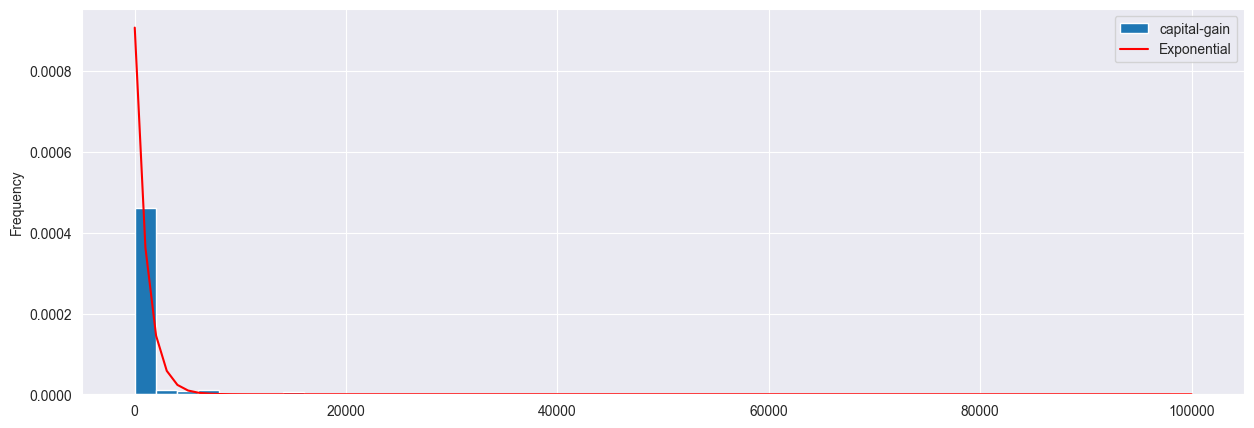

,distribution,statistic,pvalue
0,expon,0.92841,0.0


In [14]:
gimme_some_capital_gain_distributions(df['capital-gain'], 50)


I honestly do not know the best way to try to model this feature. The imbalance throws off model fitting for all the distributions we are testing. The closest fit seems to be an exponential distribution, but, as we see in the table with the KS test output, the KS statistic is pretty high. 

So we will consider dropping this feature. We are unlikely to find a known parametric distribution that we can sample from for it. We could look at using nonparametric models or even adding more complexity with ANNs, but, as is a theme for this project, I want to be careful in terms of scope, and trying to parse out the papers with much more complicated modeling for specific features pulls us away from our core focus. I do suspect that this feature will end up being important for predictive power due to individuals who have capital gains being ones who have higher incomes, so we can consider a split approach where we may ignore this feature during some modeling and include it for others. We will test out linearity assumptions after a pass of EDA for each feature.

Similar to above, we can proceed forward with a proof-of-concept of modeling with this distribution knowing that we will need to return here if we want to use models that require known distributions beforehand in a production setting.

Next we will check out `capital-loss` to see if it shares the same issues as `capital-gain`.


Mean of capital-loss: 88.60
Median of capital-loss: 0.0
Mode of capital-loss: ModeResult(mode=np.int64(0), count=np.int64(43082))



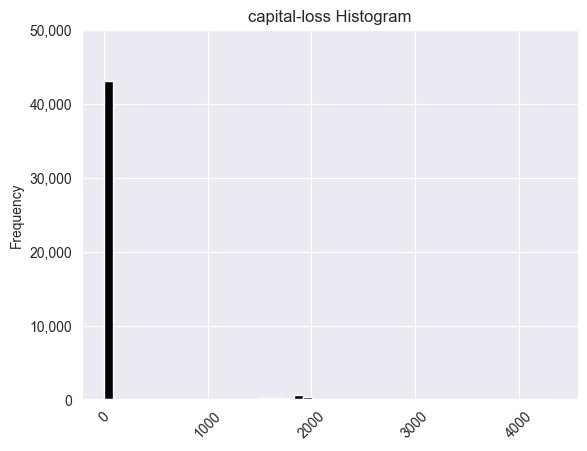

In [15]:
ax = df['capital-loss'].plot(
    kind='hist'
    , bins=50
    , title='capital-loss Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('capital-loss')


We see a similar plot to what we saw in `capital-gain`. An overwhelming preponderance of values are 0s. Again, this is likely to cause problems for fitting a parametric distribution to the empirical data.

In [16]:
print(
    f'There are {df.loc[df['capital-loss'] != 0, 'capital-loss'].shape[0]:,} rows with non-zero values for capital-loss, '
    f'{df.loc[df['capital-loss'] != 0, 'capital-loss'].shape[0] / df.shape[0]:0.2f} of the total number of rows\n\n'
)
df['capital-loss'].value_counts().sort_index()


There are 2,140 rows with non-zero values for capital-loss, 0.05 of the total number of rows




capital-loss
0       43082
155         1
213         5
323         5
419         1
        ...  
3175        2
3683        2
3770        4
3900        2
4356        1
Name: count, Length: 97, dtype: int64

In [17]:

def gimme_some_capital_loss_distributions(col, nbins):
    params_expon = expon.fit(col)
    # params_gamma = gamma.fit(col)
    # params_beta = beta.fit(col)
    # params_weibull = weibull_min.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    # plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma', density=True)
    # plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta', density=True)
    # plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull', density=True)
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
    ], axis=0
)

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


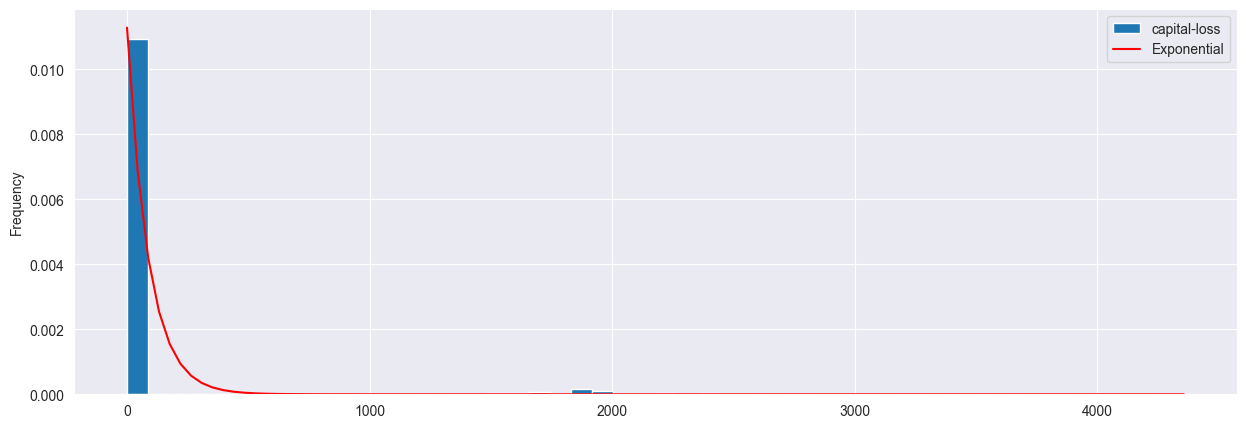

,distribution,statistic,pvalue
0,expon,0.451074,0.0


In [18]:
gimme_some_capital_loss_distributions(df['capital-loss'], 50)


And we do see similar issues with `capital-loss`. Again, most of the distributions we are testing do not fit the empirical data well. Going through them one-by-one does not help the situation -- even after toying around to try and get the fits working. Some fail because of the 0 values. Others return 0.0 p-values, indicating that that distribution does not capture the empirical data. All of my thoughts for `capital-gain` apply here, including my hypothesis this feature is likely important for predictive power due to individuals with capital losses also being those who have higher incomes, though we will struggle to find a parametric distribution we can easily sample from to generate synthetic values for this feature.

`capital-loss` does have fewer non-zero rows than `capital-gain`. The range for the losses is also smaller than the range for the gains, and the gains have the winsorized cutoff at 99,999, so the actual range for the gains is actually wider.

Our strategy for `capital-loss` is the same as for the previous feature. We will hold off on trying to fit a specific distribution for this feature, meaning we will leave it out for models in which we need to provide distributions ahead of time.

Next we will look at our final numeric feature.

Mean of hours-per-week: 40.94
Median of hours-per-week: 40.0
Mode of hours-per-week: ModeResult(mode=np.int64(40), count=np.int64(21358))



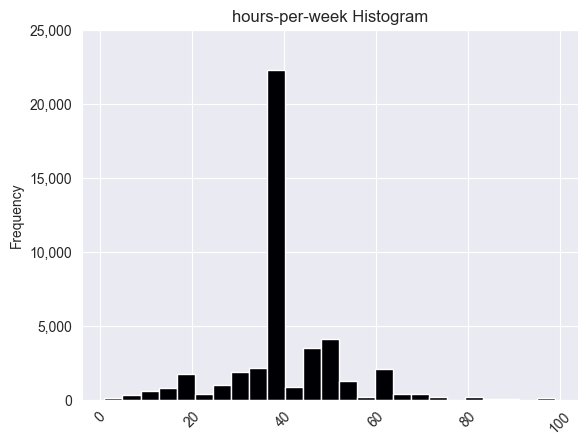

In [19]:
ax = df['hours-per-week'].plot(
    kind='hist'
    , bins=25
    , title='hours-per-week Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages('hours-per-week')


`hours-per-week` looks sort of normal-ish with a big spike around 40. The mean, median, and mode are all in the same ballpark, though the mean is a slight bit higher, indicating a bit of right skew, which we can see visually. This may be capturing the fact that a significant-enough number of individuals work around 50-55 hours per week in particular.

It is a stretch, but we may be able to consider this multimodal with the 40ish and 50ish values as the two modes.

In [20]:

def gimme_some_hours_per_week_distributions(col, nbins):
    params_expon = expon.fit(col)
    params_norm = norm.fit(col)
    params_skewnorm = skewnorm.fit(col)
    params_lognorm = lognorm.fit(col)
    params_t = t.fit(col)
    params_gamma = gamma.fit(col)
    # params_beta = beta.fit(col)
    params_weibull = weibull_min.fit(col)
    params_cauchy = cauchy.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    plt.plot(x, norm.pdf(x, *params_norm), color='g', label='Normal')
    plt.plot(x, skewnorm.pdf(x, *params_skewnorm), color='b', label='Skewed Normal')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), color='c', label='LogNormal')
    plt.plot(x, t.pdf(x, *params_t), color='m', label="Student's T")
    plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull')
    plt.plot(x, cauchy.pdf(x, *params_cauchy), color='tab:pink', label='Cauchy')
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['norm', *[*kstest(df['age'], 'norm', params_norm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['skewnorm', *[*kstest(df['age'], 'skewnorm', params_skewnorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['lognorm', *[*kstest(df['age'], 'lognorm', params_lognorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['t', *[*kstest(df['age'], 't', params_t)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['cauchy', *[*kstest(df['age'], 'cauchy', params_cauchy)]], (-1, 3)), columns=col_names)
    ], axis=0
    )

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='statistic', ascending=True)


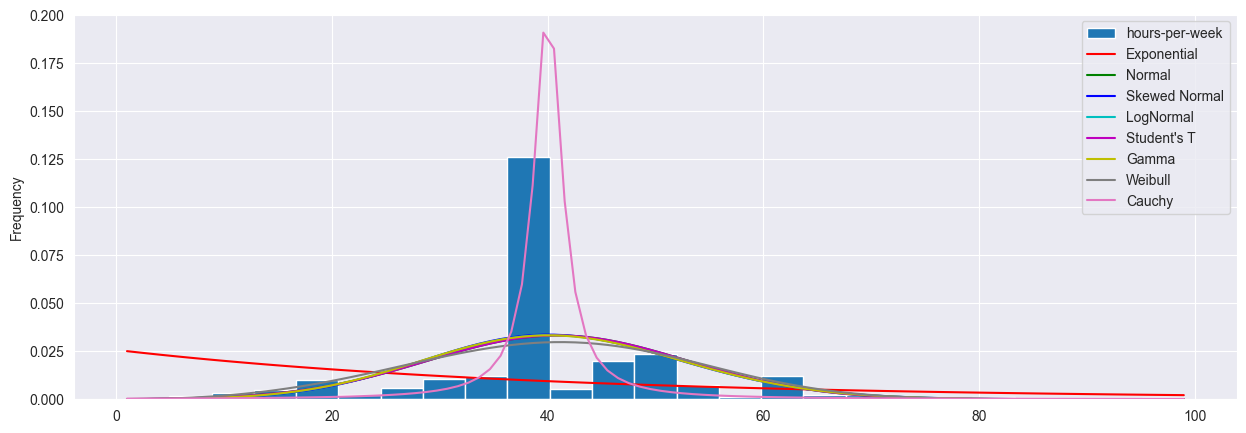

,distribution,statistic,pvalue
0,weibull,0.118331,0.0
0,gamma,0.138964,0.0
0,lognorm,0.140824,0.0
0,skewnorm,0.143108,0.0
0,norm,0.143960,0.0
0,t,0.143960,0.0
0,expon,0.336547,0.0
0,cauchy,0.365733,0.0


In [21]:
gimme_some_hours_per_week_distributions(df['hours-per-week'], 25)

Not surprisingly, the distributions return 0.0 for p-values, again indicating that none of them fit the data well. But, looking at the plots, almost all the distributions we are testing end up with almost the same PDF line, the exponential and Cauchy distributions excepted. The Cauchy distribution captures the spike around 40 better than the rest, but the other distributions, minus the exponential, capture the non-40-ish values better. The Weibull has the lowest KS test statistic, so we will stick with the Weibull distribution.

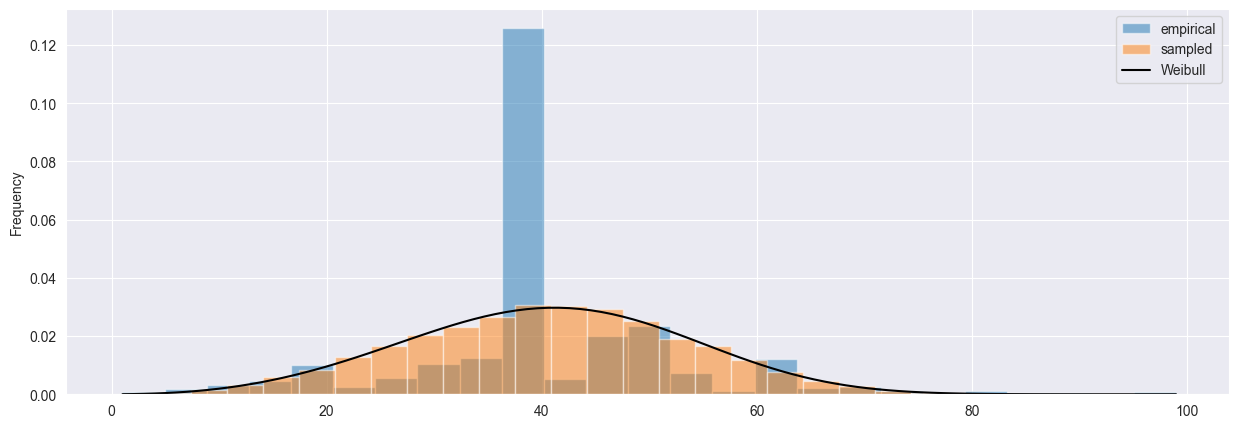

Weibull distribution parameters are:
shape=3.5979
location=-1.2358
scale=46.4293


In [22]:
params_hours_per_week = weibull_min.fit(df['hours-per-week'])

df['hours-per-week'].plot(
    kind='hist'
    , bins=25
    , density=True
    , figsize=(15, 5)
    , alpha=0.5
    , label='empirical'
)
plt.hist(
    weibull_min.rvs(c=params_hours_per_week[0], loc=params_hours_per_week[1], scale=params_hours_per_week[2], size=10000)
    , bins=25
    , density=True
    , alpha=0.5
    , label='sampled'
)
xs = np.linspace(min(df['hours-per-week']), max(df['hours-per-week']), 100)
plt.plot(xs, weibull_min.pdf(xs, *params_hours_per_week), color='k', label='Weibull')
plt.legend()
plt.show()

print(
    f'Weibull distribution parameters are:\nshape={params_hours_per_week[0]:.4f}\n'
    f'location={params_hours_per_week[1]:.4f}\nscale={params_hours_per_week[2]:.4f}'
)


This should be good for the `hours-per-week` feature. We have a first pass at a fitted distribution. It missed the major spike around 40, but it captures the overall shape of the rest of the data, and it seems to capture the ends of the data well enough.

So, in summary, we have one feature that is possibly multimodal, though the spike in the center is pretty significant and outweighs the remaining values. We have two features with a huge imbalance of 0s. We have two features with proposed distributions we can at least start to play with in modeling. We do have some outliers that we may want to clean up later, but I am curious how the modeling will handle the features as-is. We can always drop extreme values later when playing around with modeling.

One thing that occurs to me after exploring the features is that the difficulty in finding clear distributions can be a boon for this project. Real world data is messy. It is reasonable to have features such as `capital-gain` and `capital-loss` where most rows are 0s but the non-zero values are significant. All of this is to say that while we spent awhile exploring the numeric features and deciding to leave most changes alone for now until we get into modeling and the feedback we receive there, this is a good dataset to test out with deep learning to see if it can adequately capture these complicated data.

### Categorical Features

We have twice as many categorical features as numeric features, ignoring the `income` target. We will end up one-hot encoding the categorical features we keep, so, to make the iterative process of model refinement easier and since we do not need to keep all of these categorical features, we may want to keep features with fewer classes in them so we do not balloon the encoded feature space. We do want to keep the binary `sex` feature since it is our only two-class feature that is not the classification target.

We want to keep an eye out for anything that looks abnormal in the coming visualizations, but we want to keep a particular focus on class imbalance since it comes up in the papers as a known issue for synthetic tabular data generation.


In [23]:
def gimme_some_counts(col):
    df_counts = pd.DataFrame(
        col.value_counts()
    )
    df_counts['pct'] = np.round(df_counts['count']/len(col), 3)
    return df_counts

,count,pct
workclass,,
Private,33307,0.737
Self-emp-not-inc,3796,0.084
Local-gov,3100,0.069
State-gov,1946,0.043
Self-emp-inc,1646,0.036
Federal-gov,1406,0.031
Without-pay,21,0.000


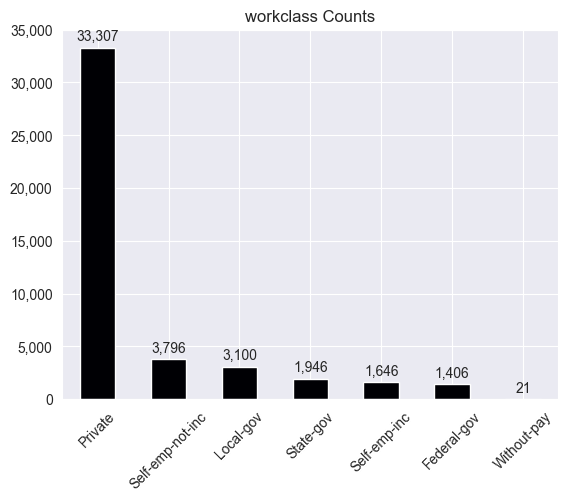

In [24]:
ax = df['workclass'].value_counts().plot(
    kind='bar'
    , title='workclass Counts'
    , rot=45
    , cmap='magma'
)
# Not sure why these plots require removing x labels separately, but at least it works
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['workclass'])


And our first categorical feature has some hefty imbalance. `Private` and `Without-pay` are over- and underrepresented respectively. These both make sense in terms of meaning. `workclass` might be a good feature to explore for handling imbalanced discrete features as described in paper [3] earlier. But, the process described earlier pulls one row from each class in order to keep the number of rows per class equal, avoiding the imbalance issues, but that means we can only pull up to 21 rows in total if we include `Without-pay`, a number that is likely too small to be practical. We will keep this feature in our back pocket as we check if others may be easier to work with.

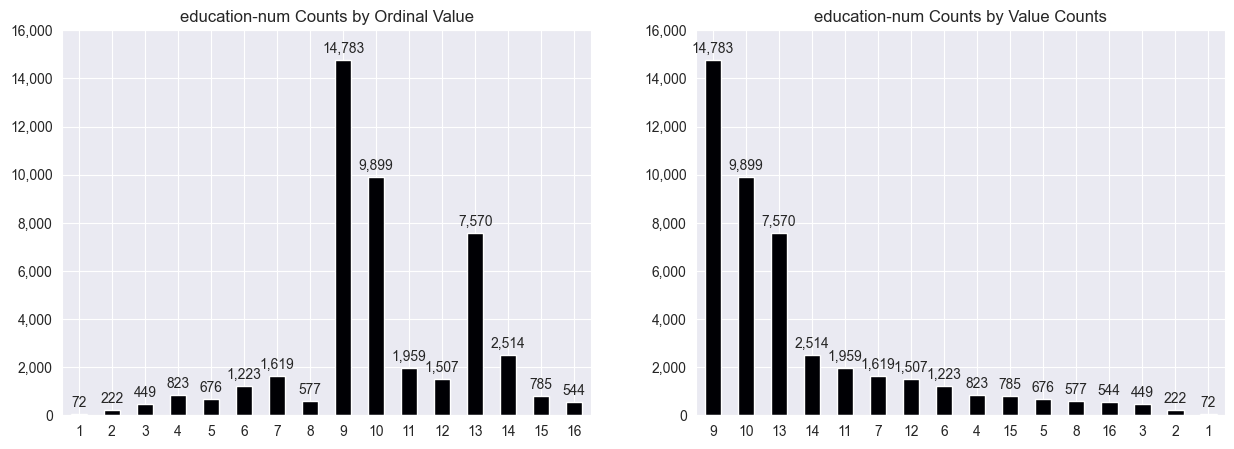

In [25]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

ax = df['education-num'].value_counts().sort_index().plot(
    kind='bar'
    , title='education-num Counts by Ordinal Value'
    , rot=0
    , cmap='magma'
    , ax=axes[0]
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


ax = df['education-num'].value_counts().plot(
    kind='bar'
    , title='education-num Counts by Value Counts'
    , rot=0
    , cmap='magma'
    , ax=axes[1]
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

plt.show()


`education-num` levels:
- 1: Preschool
- 2: 1st-4th
- 3: 5th-6th
- 4: 7th-8th
- 5: 9th
- 6: 10th
- 7: 11th
- 8: 12th
- 9: HS-grad
- 10: Some-college
- 11: Assoc-voc
- 12: Assoc-acdm
- 13: Bachelors
- 14: Masters
- 15: Prof-school
- 16: Doctorate

`education-num` is our only ordinal feature, though it too has some significant class imbalance, and it has quite a number of classes. Since it is ordinal, we do not need to one-hot encode it. It is not surprising that the most common classes are high school graduate, some college, and bachelor's degree. We expect to see positive correlation with this feature and `income` due to those with higher levels of education typically having higher incomes.

The papers do not speak about handling ordinal features specifically. If we treat these levels as different classes (as we should), then we have a class imbalance problem, so we could test out techniques to handle this from [3]. Despite the imbalance, this is a good feature to keep due to it being ordinal and having class imbalance if we choose to explore addressing that imbalance during modeling.


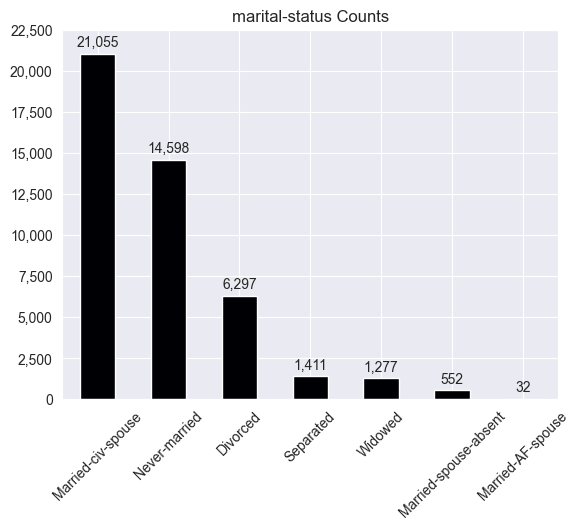

In [26]:
ax = df['marital-status'].value_counts().plot(
    kind='bar'
    , title='marital-status Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


`marital-status` has more of a taper from left to right compared to `workclass` and its steep drop. I prefer this to `workclass`, but we do have a better categorical feature to check out coming up.

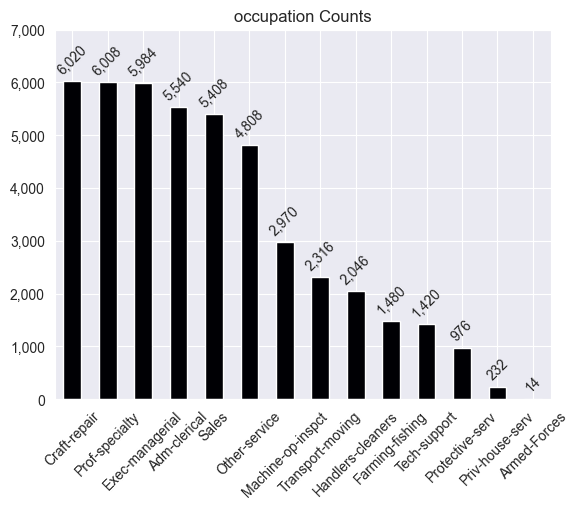

In [27]:
ax = df['occupation'].value_counts().plot(
    kind='bar'
    , title='occupation Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
    , rotation=45
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


`occupation-counts` has more factor levels with higher values, leaving us with less extreme imbalance issues, though 14 levels is a high amount once we one-hot encode the feature. There are few enough classes with smaller counts that we could look at dropping rows to remove those classes and balance this feature even further, also reducing the number of new columns after encoding. If we go this route, we will likely drop the 3-5 classes with the smallest counts.

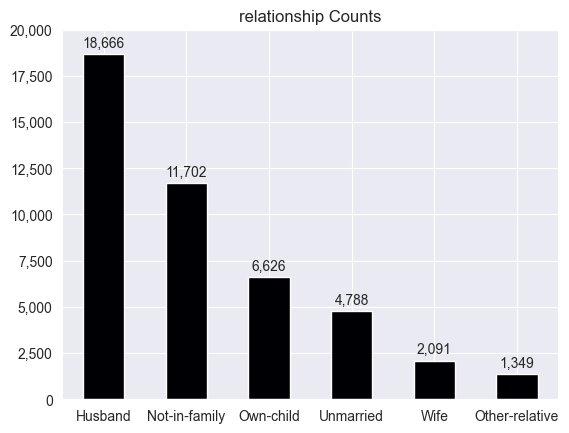

In [28]:
ax = df['relationship'].value_counts().plot(
    kind='bar'
    , title='relationship Counts'
    , rot=0
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


In terms of the shape of this feature, we again see a smoother taper, and the smallest class has many more rows compared to some of the other categorical features, meaning training-by-sampling may work better on this feature. We also only have 6 classes in this feature, preferable for one-hot encoding.

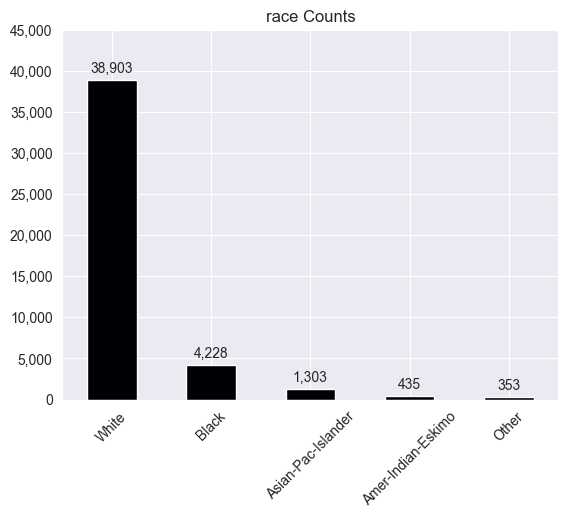

In [29]:
ax = df['race'].value_counts().plot(
    kind='bar'
    , title='race Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


Similar to `workclass`, `race` has a single overrepresented class with the remaining classes not showing up much. Ignoring the meaning of the data due to our focus on synthetic data generation, there is nothing new with this feature that we have not seen above, though `race` would be a good feature to include after gaining more facility with the generative models in order to explore ways to adjust generation to handle biased datasets, though that is beyond the scope of this iteration of this project.

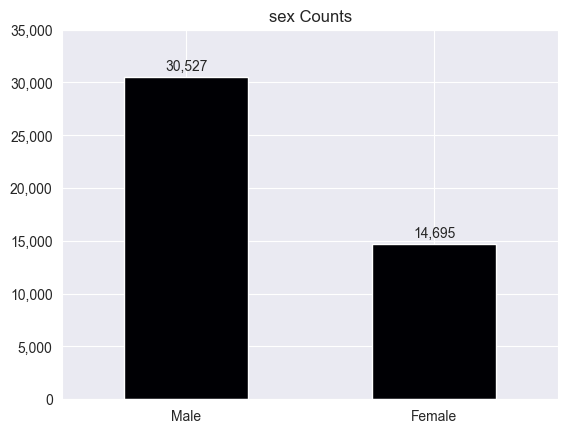

In [30]:
ax = df['sex'].value_counts().plot(
    kind='bar'
    , title='sex Counts'
    , rot=0
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


We will keep `sex` in our modeling dataset since it is the only non-target binary feature. There is a noticeable class imbalance, and, since we only have two classes, this may be our feature to explore addressing class imbalance with if we get that far in the modeling.

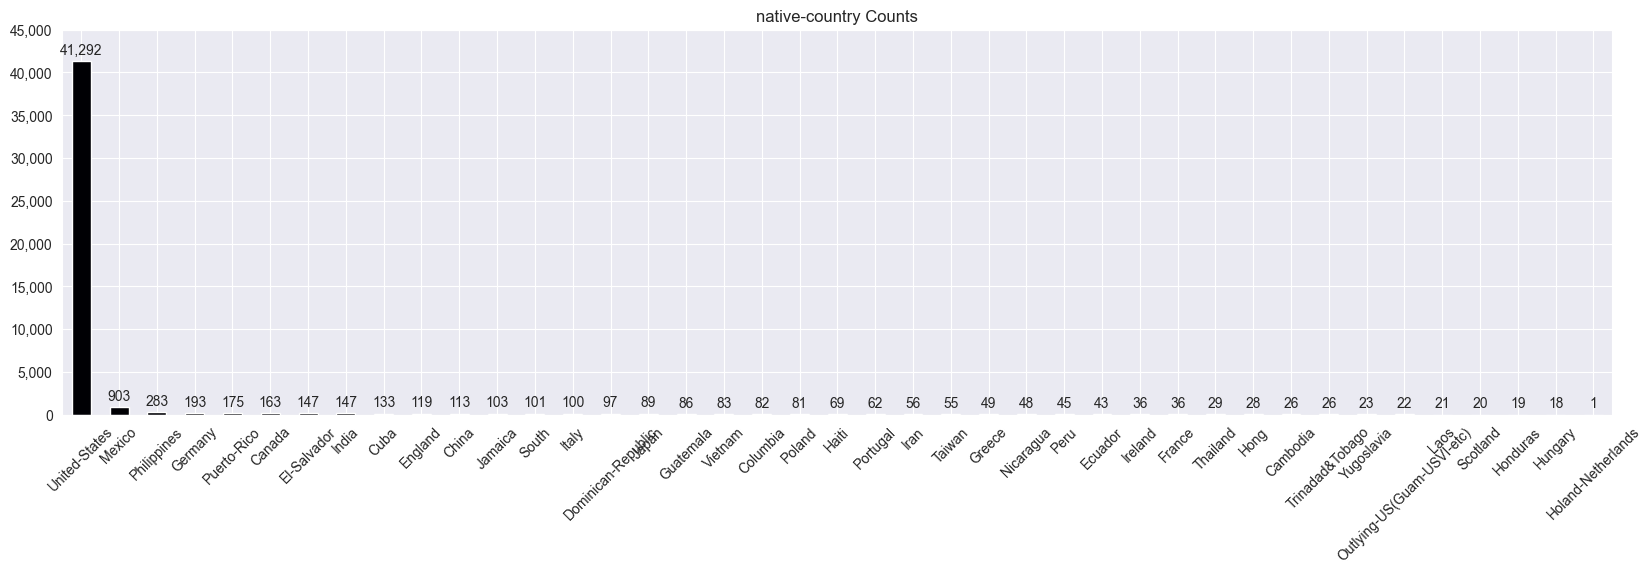

In [31]:
ax = df['native-country'].value_counts().plot(
    kind='bar'
    , title='native-country Counts'
    , rot=45
    , cmap='magma'
    , figsize=(20, 5)
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


There are many countries in the dataset. Too many to be useful. And we have a severe imbalance for individuals from the United States. Even if we were to keep this feature, one-hot encoding it would create a gazillion new features, increasing the sparsity of the modeling dataset beyond what I am comfortable with. So, `native-country` will be a feature we drop before modeling.

train
-------
 income
<=50K    24720
>50K      7841
Name: count, dtype: int64 

Train <=50K:  0.76 
Train >50K:  0.24


test
-------
 income
<=50K.    12435
>50K.      3846
Name: count, dtype: int64 

Test <=50K:  0.76 
Test >50K:  0.24 




Combined <=50K:  0.75 
Combined <=50K:  0.25 



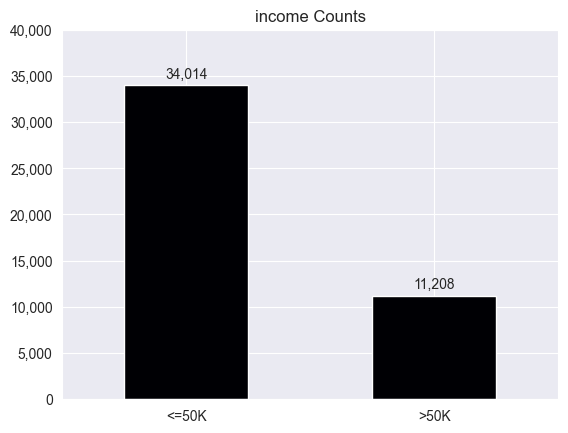

In [32]:
print(
    'train\n-------\n'
    , pd.read_csv(
        './data/adult.data'
        , names=col_names
        , skipinitialspace=True
    )['income'].value_counts()
    , f'\n\nTrain <=50K: {24720/(24720+7841): 0.2f}'
    , f'\nTrain >50K: {7841/(24720+7841): 0.2f}'
)


print(
    '\n\ntest\n-------\n'
    , pd.read_csv(
        './data/adult.test'
        , names=col_names
        , skipinitialspace=True
        , skiprows=1
    )['income'].value_counts()
    , f'\n\nTest <=50K: {12435/(12435+3846): 0.2f}'
    , f'\nTest >50K: {3846/(12435+3846): 0.2f}'
    , '\n\n'
)

print(
    f'\n\nCombined <=50K: {34014/(34014+11208): 0.2f}'
    , f'\nCombined <=50K: {11208/(34014+11208): 0.2f}'
    , '\n'
)

ax = df['income'].value_counts().plot(
    kind='bar'
    , title='income Counts'
    , rot=0
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


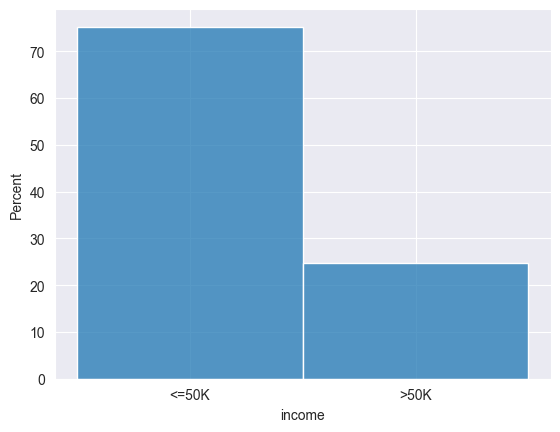

In [33]:
sns.histplot(df['income'], stat='percent');


Finally, we check out the target `income` feature. While the focus of this project is not on building a supervised classification model, we will use classification to test out our synthetic data. As a reminder from above, we will build classification models on the real data and on synthetic tables created from models trained on the real data. If both sets of classification models have similar performance, then it may indicate that our synthetic data generation modeling is working.

`income` has its own class imbalance with one class being three times the size of the other, giving us a 75-25 split. The base train and test datasets that we combined above each have the same split as well. This is fine for the classification modeling we will use in this project.

### And the Winning Features Are...

Informed by the EDA above, we will keep `age` and `hours-per-week`. The other two numeric features are too imbalanced with most of their values being 0s. If we were dealing with a straight classification problem, the non-zero values could be useful, but they will cause more issues than we need to include at the moment in this project.

As for discrete features, we will keep `education-num` and `sex` as our only ordinal and binary features respectively, excepting the binary target feature `income` that we will also keep for classification testing. We will also keep `occupation` and `relationship` as standard nominal features. The remaining discrete features have too much imbalance, especially when we have features that will be easier to work with for modeling, so we will drop the remaining discrete features.


In [34]:
print(f'occupation has {df['occupation'].value_counts().shape[0]} classes\n')

pd.merge(
    pd.DataFrame(df['occupation'].value_counts())
    , np.round(pd.DataFrame(df['occupation'].value_counts()/df.shape[0]), 3)
    , on='occupation'
)


occupation has 14 classes



,count_x,count_y
occupation,,
Craft-repair,6020,0.133
Prof-specialty,6008,0.133
Exec-managerial,5984,0.132
Adm-clerical,5540,0.123
Sales,5408,0.120
Other-service,4808,0.106
Machine-op-inspct,2970,0.066
Transport-moving,2316,0.051
Handlers-cleaners,2046,0.045


In [35]:
print(f'relationship has {df['relationship'].value_counts().shape[0]} classes\n')

pd.merge(
    pd.DataFrame(df['relationship'].value_counts())
    , pd.DataFrame(df['relationship'].value_counts()/df.shape[0])
    , on='relationship'
)


relationship has 6 classes



,count_x,count_y
relationship,,
Husband,18666,0.412764
Not-in-family,11702,0.258768
Own-child,6626,0.146522
Unmarried,4788,0.105878
Wife,2091,0.046239
Other-relative,1349,0.029831


We need to decide if we want to trim `occupation` down by removing a number of the smallest classes. It currently has 14 unique classes, so one-hot encoding this feature will triple the width of the dataset. We are also planning to one-hot encode `relationship`, further increasing the width and sparsity of the modeling dataset. If we remove the 8 smallest classes, we end up with 6 classes left, and we drop around 25% of the rows.

Another option is to drop `occupation` altogether due to the number of classes. We will keep `relationship` and get the six one-hot encoded features it brings with it. This will leave us with close to the same number of one-hot encoded an non-one-hot encoded columns. It is not the best outcome due to the sparsity approaching 50%, but it is more manageable than having a modeling dataset that is even more sparse.

We will go with the simpler approach and drop`occupation` for now. We may need to revisit the modeling dataset based on the aspects of modeling we explore anyways, so it is preferable to begin simpler and add complexity in as needed.

Note that we have a share breakdown for `relationship` that we can compare to what we get from the synthetic feature later.


In [36]:
df_encoded = df.drop(
    columns=[
        'capital-gain'
        , 'capital-loss'
        , 'workclass'
        , 'education' # We will work with the version of this feature that is already numerically encoded
        , 'marital-status'
        , 'occupation' # We can return to this feature later on if needed
        , 'race'
        , 'native-country'
    ]
).reset_index().copy()

print(f'The encoded dataset now has {df_encoded.shape[1]} columns')


The encoded dataset now has 7 columns


Now that we have our first modeling dataset, we need to handle encoding and check if we have enough correlations left for classification to make sense during later evaluation.

We will set the class with higher counts to 0 and the other to 1 for the binary features.

For the nominal feature, we can use straight one-hot encoding since we are working with deep learning models, and we will look to translate those back into single columns for each original feature as part of the cleanup after generation. We will eventually need to address multicollinearity if we end up using generalized linear models (GLMs) for classification, but we may also be able to use another deep learning model for classification and not worry about multicollinearity concerns.

In [37]:
df_encoded['sex_encoded'] = np.where(df_encoded['sex'] == 'Male', 0, 1)
df_encoded['income_encoded'] = np.where(df_encoded['income'] == '<=50K', 0, 1)

# Note that the encoding gives us back a CSR sparse matrix, and toarray() returns the full matrix
relationship_encoder = OneHotEncoder(sparse_output=False)
relationship_encoded = pd.DataFrame(
    relationship_encoder.fit_transform(df_encoded[['relationship']])
    , columns=relationship_encoder.get_feature_names_out()
)

# Note that this mutates the modeling dataset, so this cell is not idempotent
df_encoded = pd.concat(
    [df_encoded, relationship_encoded]
    , axis=1
    # , ignore_index=True
)

# pd.concat() is being a pain and requiring we leave the ignore_index param out and drop the new index column manually here
df_encoded.drop(
    columns=['index', 'relationship', 'sex', 'income']
    , inplace=True
)

print(f'The encoded dataset now has {df_encoded.shape[1]} columns\n')
df_encoded.head()


The encoded dataset now has 11 columns



,age,education-num,hours-per-week,sex_encoded,income_encoded,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,13,40,0,0,0.0,1.0,0.0,0.0,0.0,0.0
1,50,13,13,0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,38,9,40,0,0,0.0,1.0,0.0,0.0,0.0,0.0
3,53,7,40,0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,28,13,40,1,0,0.0,0.0,0.0,0.0,0.0,1.0


And now that we have the modeling dataset encoded, we can check out a correlation matrix to see if anything pops out as a last EDA check.

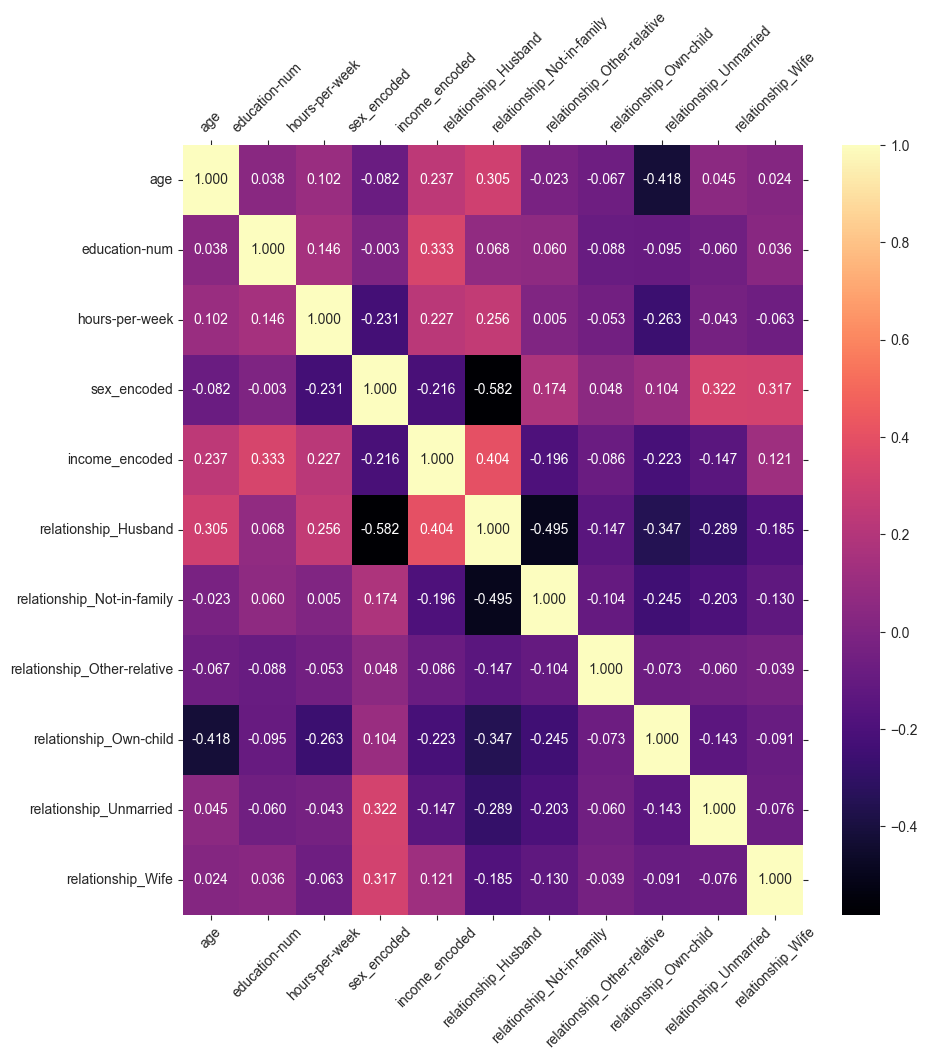

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(
    df_encoded.corr()
    , cmap='magma'
    , annot=True
    , annot_kws={'size': 10}
    , fmt='.3f'
);

plt.tick_params(
    left=True
    , top=True
    , right=True
    , bottom=True
    , labelleft=True
    , labeltop=True
    , labelright=False
    , labelbottom=True
);

plt.xticks(rotation=45);

We see some correlation with `income_encoded`. Education level and if someone is a husband show the highest correlations. A handful of features have slightly lower correlations as well, including more of the encoded features. 

This hopefully provides some evidence that building classification models on both the real and synthetic data to compare performance later for during model evaluation should work.

### Preprocessing and EDA Summary

We want most of the complexity of this project to focus on modeling, but we still want to make sure to do a thorough analysis of the data before jumping into modeling. The dataset already had some preprocessing done on it before we got our hands on it, but there were still a number of decisions to be made for our own preprocessing.

We did a bit of cleaning up invalid ? values, and then we jumped into visual inspection of each feature. We kept two numeric features with initial estimates for underlying distributions that attempt to fit the empirical data. The goal for identifying underlying distributions is in case we want to sample from random variables with those distributions as a simplified form of modeling, though we have yet to see if we will explore that avenue.

For the discrete columns, we selected two binary features -- one being the target for classification -- one ordinal feature, and one nominal feature, with one other nominal feature in our back pocket in case we need to pull it in later. We one-hot encode the nominal feature, keeping all the classes in the dataset, possibly creating multicollinearity issues depending on how we approach classification later. We encode the binary features into numeric representations.

The correlation matrix run on the encoded dataset is promising in terms of showing correlations with `income` that our models will hopefully pick up on during that part of model evaluation.

Next we will jump into modeling implementation.


## Modeling

We discussed general approaches to synthetic data generation modeling. The complexity just with that was higher than originally expected. Here we will pick some approaches and see if coding them up helps to understand what we read in the papers. We will separate out summaries and coding chunks as we proceed further into more complex and/or effective models rather than doing too much theory ahead of time.

Evaluation
- evaluation functions
    - per-columns stats
    - maybe column-wise correlation or mutual information
- check linearity assumptions for classifier
- precalculate per-column stats for real data

Models
- naive sampling
    - using distributions from above for continuous features
    - sampling from discrete features based on proportion of values in real data
    - don't have any information shared between columns
- Maybe don't worry about multimodal continuous features since we do not have them
- Point out that letting the ANN learn the continuous distributions may work better than what we did above, and they do so by minimizing KL divergence

### But First, We Need Some Tests

As a reminder, one of the methods for evaluating models is to take the real data and a synthetic dataset, train classifiers on both, and then see how each of those trained classifiers perform on a held-out test set. So, we need to snag that test set and keep it aside for checking classification performance.


In [39]:
x_train, x_test, y_train, y_test = train_test_split(
    df_encoded.drop('income_encoded', axis=1)
    , df_encoded['income_encoded']
    , test_size=0.2
    , stratify=df_encoded['income_encoded']
    , random_state=42
)

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(df_encoded.shape)


(36177, 10)
(9045, 10)
(36177,)
(9045,)
(45222, 11)



### Naive Independent Random Variables


## References

Academic papers (core to project)
- https://arxiv.org/abs/1907.00503 (Modeling Tabular Data using Conditional GAN)
- https://arxiv.org/abs/1811.11264 (Synthesizing Tabular Data using Generative Adversarial Networks)
- https://www.vldb.org/pvldb/vol11/p1071-park.pdf (Data Synthesis based on Generative Adversarial Networks)
- https://arxiv.org/abs/2303.01230v3 (Synthetic Data: Methods, Use Cases, and Risks)

Academic papers (references for project)
- https://www2.stat.duke.edu/~jerry/Papers/jos03.pdf (Multiple Imputation for Statistical Disclosure Limitation)
- https://www2.stat.duke.edu/~jerry/Papers/sm04.pdf (Simultaneous Use of Multiple Imputation for Missing Data and Disclosure Limitation)
- https://dl.acm.org/doi/10.1145/3636424 (A Survey of Generative Adversarial Networks for Synthesizing Structured Electronic Health Records)
- https://arxiv.org/abs/1609.05473 (SeqGAN: Sequence Generative Adversarial Nets with Policy Gradient)
- https://arxiv.org/abs/1611.04051 (GANs for Sequences of Discrete Elements with the Gumbel-softmax Distribution)
- https://arxiv.org/abs/1810.06640 (Adversarial Text Generation Without Reinforcement Learning)
- https://arxiv.org/abs/2403.04190v1 (Generative AI for Synthetic Data Generation: Methods, Challenges, and the Future)
- https://arxiv.org/abs/1511.06434 (Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks)

Web articles
- https://medium.com/@aldolamberti/synthetic-data-101-synthetic-data-vs-real-dummy-data-237d790433a9
- https://machinelearningmastery.com/mostly-generate-synethetic-data-machine-learning-why/
- https://towardsdatascience.com/generative-ai-synthetic-data-generation-with-gans-using-pytorch-2e4dde8a17dd
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-3-non-rl-methods-70d1be02350b
- https://towardsdatascience.com/how-to-generate-tabular-data-using-ctgans-9386e45836a6
- https://medium.com/analytics-vidhya/a-step-by-step-guide-to-generate-tabular-synthetic-dataset-with-gans-d55fc373c8db
- https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf
- https://www.geeksforgeeks.org/gaussian-mixture-model/
- https://ocw.mit.edu/courses/18-409-algorithmic-aspects-of-machine-learning-spring-2015/e339520c4069ca5e785b29a3c604470e_MIT18_409S15_chapp6.pdf
- https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
- https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
- https://www.geeksforgeeks.org/calculating-pairwise-mutual-information-in-pandas/
- https://www.tensorflow.org/tutorials/generative/dcgan

Source code
- https://github.com/sdv-dev/TGAN
- https://github.com/sdv-dev/CTGAN

Videos
- https://www.youtube.com/watch?v=yujdA46HKwA (GANs for Tabular Synthetic Data Generation)
- https://www.youtube.com/watch?v=Ei0klF38CNs (Synthetic data generation with CTGAN)
- https://www.youtube.com/watch?v=ROLugVqjf00 (Generation of Synthetic Financial Time Series with GANs - Casper Hogenboom)
- https://www.youtube.com/watch?v=HIusawrGBN4 (What is Synthetic Data? No, It's Not "Fake" Data)
- https://www.youtube.com/watch?v=FLTWjkx0kWE (Generate Synthetic Tabular Data with GANs)
- https://www.youtube.com/watch?v=zC3_kM9Qwo0 (QuantUniversity Summer School 2020 | Generating Synthetic Data with (GANs))
